<a href="https://colab.research.google.com/github/Mainabryan/SWISS-CLOTHING-BRAND/blob/main/Swiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Employee columns missing – deriving Monthly_Sales_CHF from Sales

=== KPI SUMMARY ===
   Total_Sales_CHF  Profit_Margin_Pct  Return_Rate_Pct  AOV_CHF
0         11574.73              48.99             1.22   141.16

=== WEEKLY TRENDS (first 5 rows) ===
   Year  Week Week_Start  Sales_CHF  Profit_CHF  Returns_Pct
0  2025     1 2024-12-30     124.15       53.55          0.0
1  2025     2 2025-01-06     486.13      299.42          0.0
2  2025     3 2025-01-13     944.60      526.13          0.0
3  2025     4 2025-01-20     384.02      187.20          0.0
4  2025     5 2025-01-27     348.11      163.08          0.0

=== TOP CATEGORIES (all) ===
  Category  Sales_CHF  Profit_CHF  Profit_Margin_Pct  Return_Rate_Pct  \
5  T-shirt    2267.31     1233.60              47.95             0.00   
2   Jacket    2139.26     1186.60              50.07             0.00   
4    Shoes    1939.99     1074.71              50.62             0.00   
3    Jeans    1891.86     1011.18              46.31        

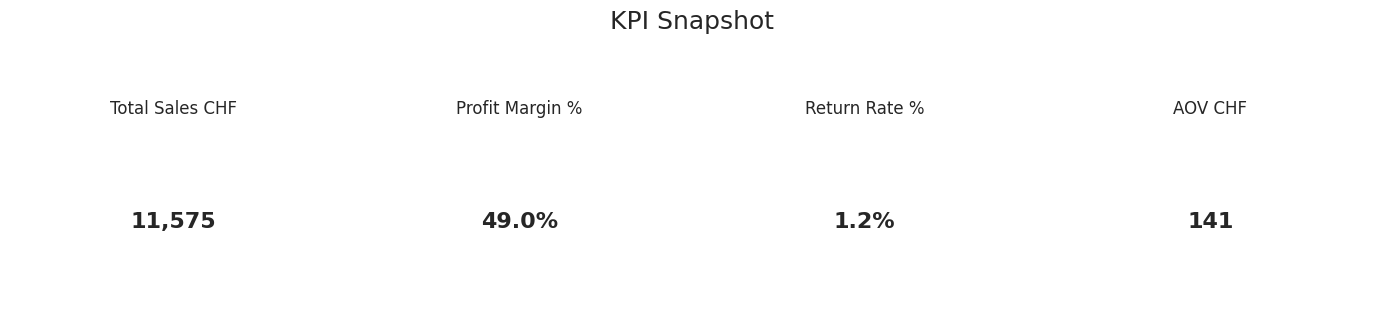

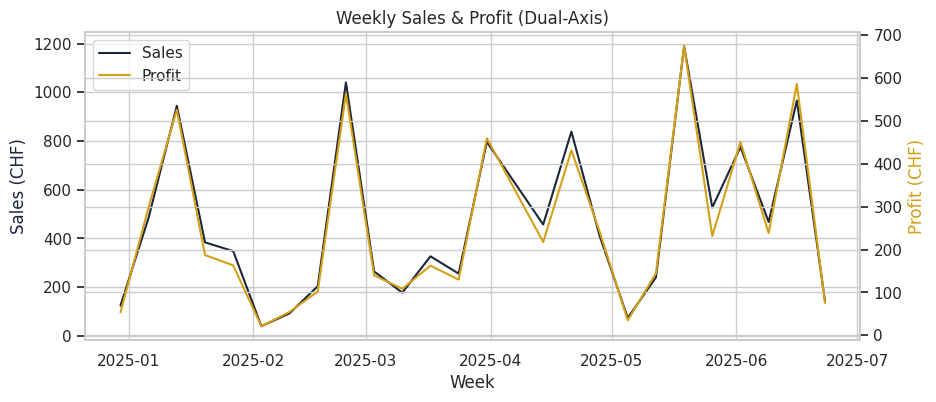

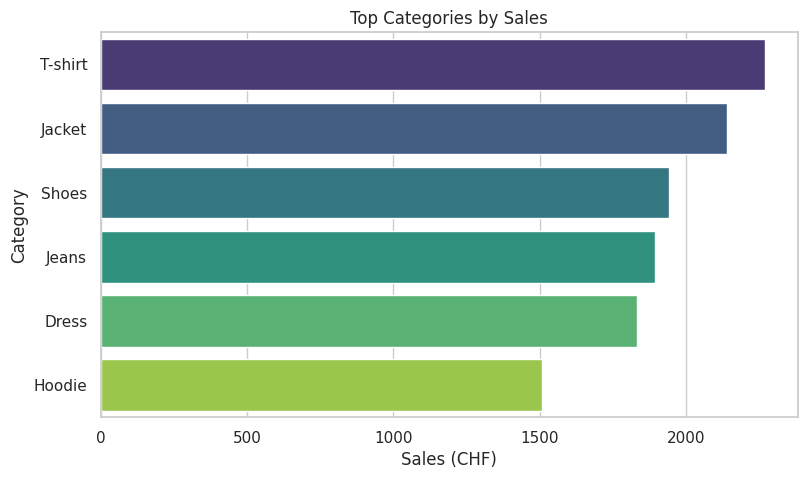

In [1]:
# --------------------------------------------------------------
# 1. IMPORTS & SETTINGS
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------------------
# 2. LOAD RAW CSVs (adjust paths if you run locally)
# --------------------------------------------------------------
sales      = pd.read_csv('/content/sales_table-sheet1-sourcetable.csv')
products   = pd.read_csv('/content/product_table-sheet1-sourcetable.csv')
customers  = pd.read_csv('/content/customer_table-sheet1-sourcetable.csv')
inventory  = pd.read_csv('/content/inventory_restock-sheet1-sourcetable.csv')
employees  = pd.read_csv('/content/employee_table-sheet1-sourcetable.csv')   # may miss columns
marketing  = pd.read_csv('/content/marketing_table-sheet1-sourcetable.csv')   # not used here

# --------------------------------------------------------------
# 3. BASIC CLEANING
# --------------------------------------------------------------
sales['Date'] = pd.to_datetime(sales['Date'])
sales = sales[(sales['Unit_Price_CHF'] < 200) & (sales['Quantity'].abs() < 10)]
sales['Discount_CHF'] = sales['Discount_CHF'].fillna(0)

# --------------------------------------------------------------
# 4. MERGE CORE TABLES
# --------------------------------------------------------------
df = (
    sales
    .merge(products[['Product_ID','Category','Cost_Price_CHF','Selling_Price_CHF','Stock_Level_initial']],
           on='Product_ID', how='left')
    .merge(customers[['Customer_ID','Loyalty_Status','Age','Town']],
           on='Customer_ID', how='left')
)

# --------------------------------------------------------------
# 5. EMPLOYEE MERGE – SAFE FALLBACK (fixes the KeyError you saw)
# --------------------------------------------------------------
try:
    # try to use the exact columns you expected
    df = df.merge(employees[['Employee_ID','Monthly_Sales_CHF']],
                  on='Employee_ID', how='left')
except Exception as e:
    print("Employee columns missing – deriving Monthly_Sales_CHF from Sales")
    emp_sales = (
        sales.groupby('Employee_ID')['Total_Price_CHF']
             .sum()
             .reset_index()
             .rename(columns={'Total_Price_CHF':'Monthly_Sales_CHF'})
    )
    df = df.merge(emp_sales, on='Employee_ID', how='left')

# --------------------------------------------------------------
# 6. DERIVED COLUMNS
# --------------------------------------------------------------
df['Profit']        = (df['Selling_Price_CHF'] - df['Cost_Price_CHF']) * df['Quantity']
df['Profit_Margin'] = ((df['Selling_Price_CHF'] - df['Cost_Price_CHF']) /
                       df['Selling_Price_CHF']) * 100
df['Is_Return']     = df['Quantity'] < 0
df['Week']          = df['Date'].dt.isocalendar().week
df['Year']          = df['Date'].dt.year
df['Week_Start']    = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# --------------------------------------------------------------
# 7. KPI SUMMARY (single row)
# --------------------------------------------------------------
kpi = {
    'Total_Sales_CHF'   : df['Total_Price_CHF'].sum(),
    'Profit_Margin_Pct' : df['Profit_Margin'].mean(),
    'Return_Rate_Pct'   : (df['Is_Return'].sum() / len(df)) * 100,
    'AOV_CHF'           : df['Total_Price_CHF'].sum() / df['Sale_ID'].nunique()
}
kpi_df = pd.DataFrame([kpi])
kpi_df.to_csv('kpi_summary.csv', index=False)
print("\n=== KPI SUMMARY ===")
print(kpi_df.round(2))

# --------------------------------------------------------------
# 8. WEEKLY TRENDS (for dual-axis line chart)
# --------------------------------------------------------------
weekly = (
    df.groupby(['Year','Week','Week_Start']).agg(
        Sales_CHF   = ('Total_Price_CHF', 'sum'),
        Profit_CHF  = ('Profit',         'sum'),
        Returns_Pct = ('Is_Return',      lambda x: x.mean()*100)
    )
    .reset_index()
    .sort_values('Week_Start')
)
weekly.to_csv('weekly_trends.csv', index=False)
print("\n=== WEEKLY TRENDS (first 5 rows) ===")
print(weekly.head())

# --------------------------------------------------------------
# 9. TOP CATEGORIES (for bar chart)
# --------------------------------------------------------------
cat = (
    df.groupby('Category').agg(
        Sales_CHF      = ('Total_Price_CHF', 'sum'),
        Profit_CHF     = ('Profit',         'sum'),
        Profit_Margin_Pct = ('Profit_Margin', 'mean'),
        Return_Rate_Pct = ('Is_Return',     lambda x: x.mean()*100),
        Qty_Sold       = ('Quantity',       lambda x: x[x>0].sum())
    )
    .reset_index()
    .sort_values('Sales_CHF', ascending=False)
)
cat.to_csv('top_categories.csv', index=False)
print("\n=== TOP CATEGORIES (all) ===")
print(cat.round(2))

# --------------------------------------------------------------
# 10. QUICK PLOTS (so you can *see* the results before Tableau)
# --------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='deep')

# ---- KPI cards (just to visualise) ----
fig, ax = plt.subplots(1,4, figsize=(14,3))
for i,(col,val) in enumerate(kpi.items()):
    ax[i].text(0.5,0.5,f"{val:,.0f}" if 'CHF' in col else f"{val:,.1f}%",
               ha='center',va='center', fontsize=16, fontweight='bold')
    ax[i].set_title(col.replace('_',' ').replace('Pct','%'), fontsize=12)
    ax[i].axis('off')
plt.suptitle('KPI Snapshot', fontsize=18, y=1.1)
plt.tight_layout()
plt.show()

# ---- Dual-axis weekly line chart ----
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(weekly['Week_Start'], weekly['Sales_CHF'], color='#1B263B', label='Sales')
ax1.set_ylabel('Sales (CHF)', color='#1B263B')
ax2 = ax1.twinx()
ax2.plot(weekly['Week_Start'], weekly['Profit_CHF'], color='#D4A017', label='Profit')
ax2.set_ylabel('Profit (CHF)', color='#D4A017')
ax1.set_xlabel('Week')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper left')
plt.title('Weekly Sales & Profit (Dual-Axis)')
plt.show()

# ---- Top categories bar chart ----
plt.figure(figsize=(9,5))
sns.barplot(data=cat, x='Sales_CHF', y='Category', palette='viridis')
plt.title('Top Categories by Sales')
plt.xlabel('Sales (CHF)')
plt.show()